# Real Estate Listings Price Prediction

In [1]:
#Senior Project 2020
#Kelsey Dinndorf
#Part 2 - Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stat
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [3]:
#insert data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5a7f0d32e3f74da881228669190705da = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='d9GnnkKQVvMXW5ZW8Gwh_62JvBA6cy47uvCw8KCnxxkh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5a7f0d32e3f74da881228669190705da.get_object(Bucket='seniorproject-donotdelete-pr-6dm4jsyzpqluep',Key='housing_crime_merged.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

hcdf = pd.read_csv(body)
hcdf.head()


,Uniq Id,Price,Sqr Ft,Beds,Bath,Year Built,Features,City,State,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate
0,d6521bac40600f17287f0a5a8b3efc8d,895900.0,3447.0,4.0,4.5,2019.0,"Single Family Home | $260/sqft | Lot Size: 7,8...",Phoenix,AZ,110.0,7895.00000,259.91,1688722,0.006989,0.033146
1,c0b021f845c16f7ae098a5e105ac9217,300825.0,2537.0,3.0,4.0,2005.0,"Single Family Home | $119/sqft | Lot Size: 5,4...",Phoenix,AZ,126.0,5400.00000,118.58,1688722,0.006989,0.033146
2,b49804a33efa41bba44312df9d2ec280,1050000.0,2443.0,4.0,2.0,1962.0,Single Family Home | $430/sqft | Lot Size: 0.3...,Phoenix,AZ,3.0,14810.40000,429.80,1688722,0.006989,0.033146
3,32b631b5d0834e3bf8983b889f1eb285,490990.0,2005.0,2.0,2.5,1975.0,Single Family Home | $245/sqft | 180+ Days on ...,Phoenix,AZ,180.0,92933.22244,244.88,1688722,0.006989,0.033146
4,81d00428d77b64bf48e90472376403c5,190000.0,1732.0,4.0,2.0,1983.0,"Single Family Home | $110/sqft | Lot Size: 9,1...",Phoenix,AZ,29.0,9165.00000,109.70,1688722,0.006989,0.033146


## Get rid of Outliers (Z-score)

In [4]:
#create new column as an index for merging later
hcdf['new_col'] = range(1, len(hcdf) + 1)
print(hcdf)

                                Uniq Id      Price  Sqr Ft  Beds  Bath  \
0      d6521bac40600f17287f0a5a8b3efc8d   895900.0  3447.0   4.0   4.5   
1      c0b021f845c16f7ae098a5e105ac9217   300825.0  2537.0   3.0   4.0   
2      b49804a33efa41bba44312df9d2ec280  1050000.0  2443.0   4.0   2.0   
3      32b631b5d0834e3bf8983b889f1eb285   490990.0  2005.0   2.0   2.5   
4      81d00428d77b64bf48e90472376403c5   190000.0  1732.0   4.0   2.0   
...                                 ...        ...     ...   ...   ...   
22422  145fbc9b268c57ceb40cfbc6ed073f56   405959.0  2853.0   4.0   3.0   
22423  27783db682ab9488ddde30714ff1f293   439900.0  2455.0   3.0   3.0   
22424  1d19ef5df394811a7e14c370f7d2111c    82650.0  1100.0   3.0   2.0   
22425  25c7af665574de143d2722fd66b4067e   149500.0  1056.0   2.0   2.0   
22426  7c41852728c9c20b2969901d96803b0c   299000.0  2392.0   4.0   3.0   

       Year Built                                           Features  \
0          2019.0  Single Family Home |

In [5]:
#get rid or change object data types
print("shape before :", hcdf.shape)
df_num = hcdf.select_dtypes(exclude=['object'])
print(df_num)

shape before : (22427, 16)
           Price  Sqr Ft  Beds  Bath  Year Built  Days On Trulia  \
0       895900.0  3447.0   4.0   4.5      2019.0           110.0   
1       300825.0  2537.0   3.0   4.0      2005.0           126.0   
2      1050000.0  2443.0   4.0   2.0      1962.0             3.0   
3       490990.0  2005.0   2.0   2.5      1975.0           180.0   
4       190000.0  1732.0   4.0   2.0      1983.0            29.0   
...          ...     ...   ...   ...         ...             ...   
22422   405959.0  2853.0   4.0   3.0      1975.0             3.0   
22423   439900.0  2455.0   3.0   3.0      1955.0           128.0   
22424    82650.0  1100.0   3.0   2.0      1975.0           136.0   
22425   149500.0  1056.0   2.0   2.0      1981.0            68.0   
22426   299000.0  2392.0   4.0   3.0      2010.0             2.0   

       Lot Size(sqft)  Price per Sqft  Population  Violent Crime Rate  \
0          7895.00000          259.91     1688722            0.006989   
1         

In [6]:
from scipy import stats
#remove outliers with Zscore
#try different numbers - don't want to get rid of too many observations that could be valuable
df_Zscore = df_num[(np.abs(stats.zscore(df_num))<4).all(axis=1)]
print("shape after rejecting outliers: ", df_Zscore.shape)

shape after rejecting outliers:  (21912, 12)


Text(0.5, 1.0, 'After Z-score')

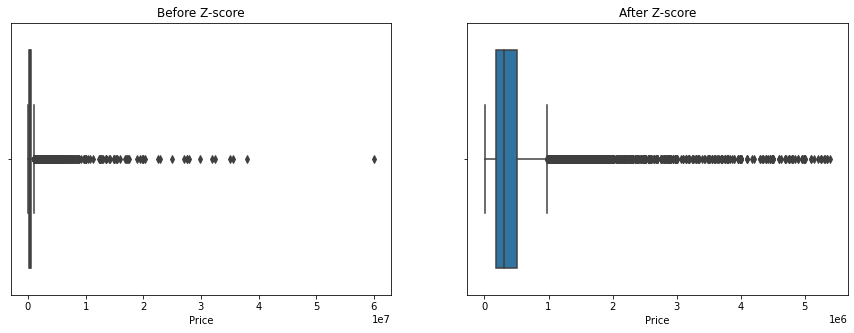

In [7]:
#boxplot of price
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Price'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Price'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

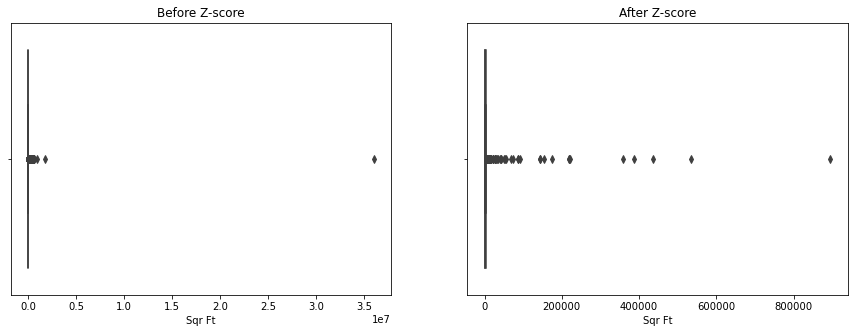

In [8]:
#boxplot of Sqr Ft

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Sqr Ft'])
plt.title('Before Z-score')


plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Sqr Ft'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

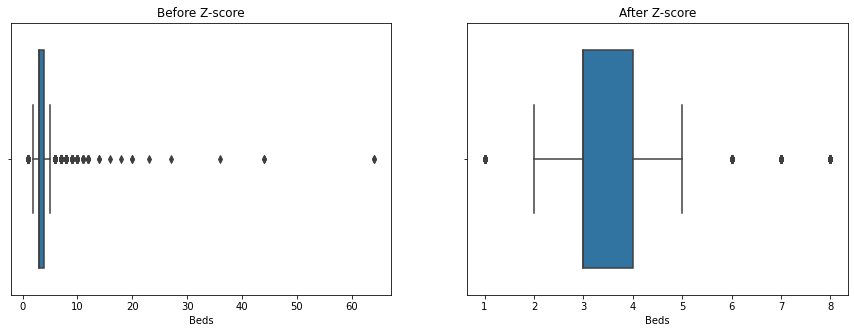

In [9]:
#boxplot of Beds

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Beds'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Beds'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

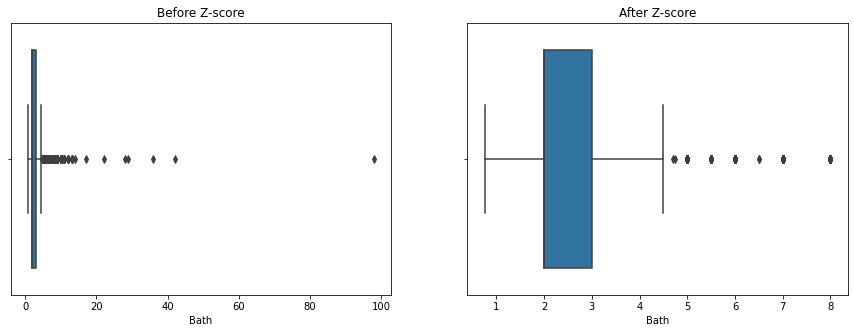

In [10]:
#boxplot of Bath

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Bath'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Bath'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

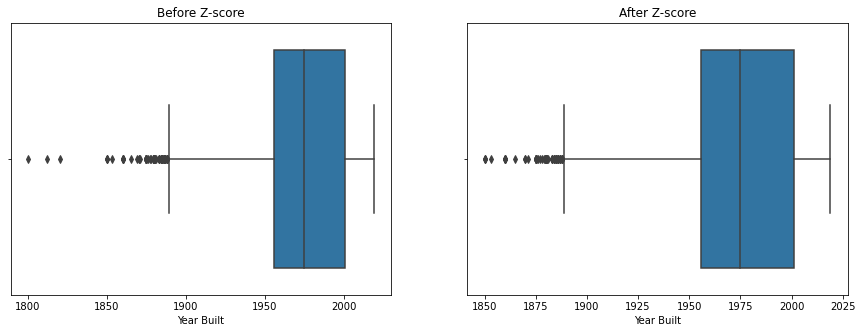

In [11]:
#boxplot of year built
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Year Built'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Year Built'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

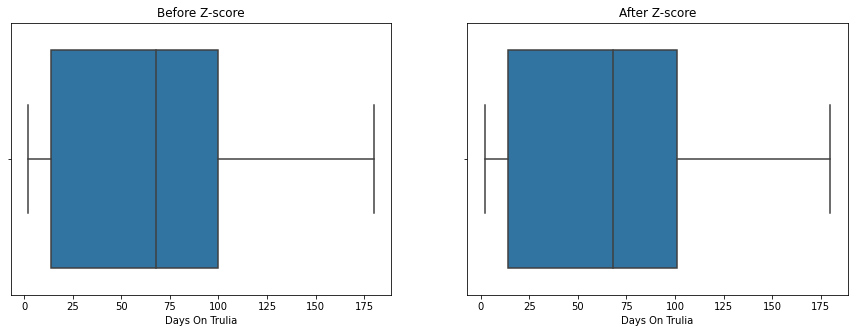

In [12]:
#boxplot of days on Trulia
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Days On Trulia'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Days On Trulia'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

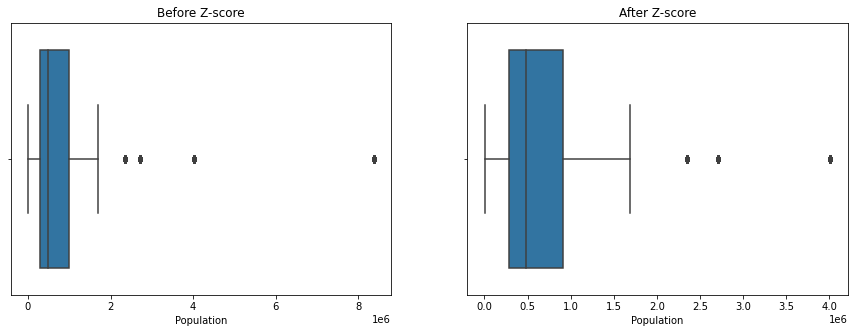

In [13]:
#boxplot of Population
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Population'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Population'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

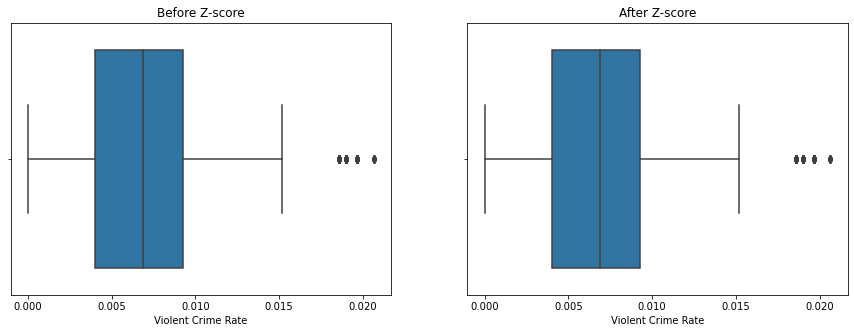

In [14]:
#boxplot of Violent Crime rate
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Violent Crime Rate'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Violent Crime Rate'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

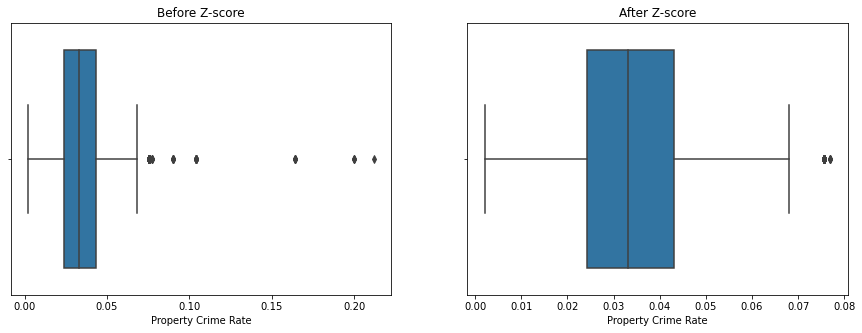

In [15]:
#boxplot of Property Crime Rate
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Property Crime Rate'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Property Crime Rate'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

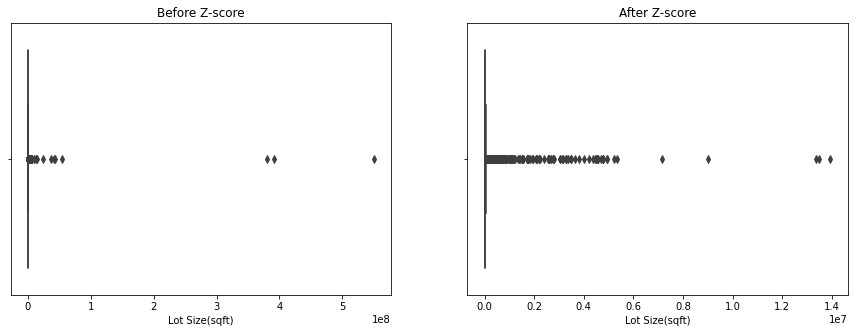

In [16]:
# Boxplot of Lot Size(sqft)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Lot Size(sqft)'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Lot Size(sqft)'])
plt.title('After Z-score')

In [17]:
#merge the cleaned z-score data with original data
dfz = pd.merge(df_Zscore, hcdf, on="new_col")
print(dfz)

         Price_x  Sqr Ft_x  Beds_x  Bath_x  Year Built_x  Days On Trulia_x  \
0       895900.0    3447.0     4.0     4.5        2019.0             110.0   
1       300825.0    2537.0     3.0     4.0        2005.0             126.0   
2      1050000.0    2443.0     4.0     2.0        1962.0               3.0   
3       490990.0    2005.0     2.0     2.5        1975.0             180.0   
4       190000.0    1732.0     4.0     2.0        1983.0              29.0   
...          ...       ...     ...     ...           ...               ...   
21907   405959.0    2853.0     4.0     3.0        1975.0               3.0   
21908   439900.0    2455.0     3.0     3.0        1955.0             128.0   
21909    82650.0    1100.0     3.0     2.0        1975.0             136.0   
21910   149500.0    1056.0     2.0     2.0        1981.0              68.0   
21911   299000.0    2392.0     4.0     3.0        2010.0               2.0   

       Lot Size(sqft)_x  Price per Sqft_x  Population_x  Violen

In [18]:
#drop duplicate y columns
cols = ['new_col','Price_y','Sqr Ft_y','Beds_y','Bath_y','Year Built_y','Days On Trulia_y','Lot Size(sqft)_y',
       'Price per Sqft_y','Population_y','Violent Crime Rate_y','Property Crime Rate_y']
dfo = dfz.drop(cols, axis=1)
print(dfo.head())

     Price_x  Sqr Ft_x  Beds_x  Bath_x  Year Built_x  Days On Trulia_x  \
0   895900.0    3447.0     4.0     4.5        2019.0             110.0   
1   300825.0    2537.0     3.0     4.0        2005.0             126.0   
2  1050000.0    2443.0     4.0     2.0        1962.0               3.0   
3   490990.0    2005.0     2.0     2.5        1975.0             180.0   
4   190000.0    1732.0     4.0     2.0        1983.0              29.0   

   Lot Size(sqft)_x  Price per Sqft_x  Population_x  Violent Crime Rate_x  \
0        7895.00000            259.91       1688722              0.006989   
1        5400.00000            118.58       1688722              0.006989   
2       14810.40000            429.80       1688722              0.006989   
3       92933.22244            244.88       1688722              0.006989   
4        9165.00000            109.70       1688722              0.006989   

   Property Crime Rate_x                           Uniq Id  \
0               0.033146  d652

In [19]:
#rename columns
dfo.columns=['Price','Sqr Ft','Bedrooms','Bathrooms','Year Built','Days On Trulia','Lot Size(sqft)','Price per Sqft',
            'Population','Violent Crime Rate','Property Crime Rate','Uniq ID','Features', 'City','State']
dfo.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,Uniq ID,Features,City,State
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,0.033146,d6521bac40600f17287f0a5a8b3efc8d,"Single Family Home | $260/sqft | Lot Size: 7,8...",Phoenix,AZ
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,0.033146,c0b021f845c16f7ae098a5e105ac9217,"Single Family Home | $119/sqft | Lot Size: 5,4...",Phoenix,AZ
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,0.033146,b49804a33efa41bba44312df9d2ec280,Single Family Home | $430/sqft | Lot Size: 0.3...,Phoenix,AZ
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,0.033146,32b631b5d0834e3bf8983b889f1eb285,Single Family Home | $245/sqft | 180+ Days on ...,Phoenix,AZ
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,0.033146,81d00428d77b64bf48e90472376403c5,"Single Family Home | $110/sqft | Lot Size: 9,1...",Phoenix,AZ


In [20]:
#drop Uniq ID and features columns for now
columns=['Uniq ID','Features']
dfm = dfo.drop(columns, axis=1)
dfm.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,City,State
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,0.033146,Phoenix,AZ
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,0.033146,Phoenix,AZ
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,0.033146,Phoenix,AZ
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,0.033146,Phoenix,AZ
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,0.033146,Phoenix,AZ


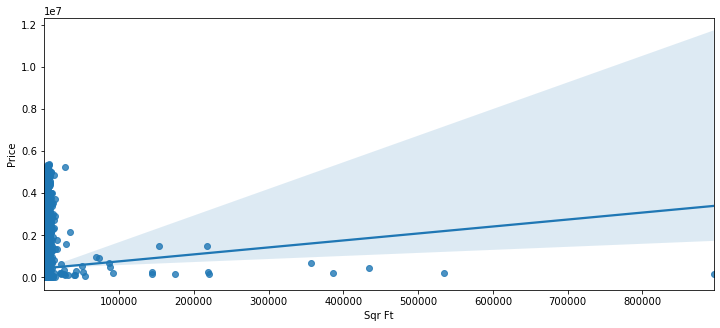

In [21]:
#regression plot for price vs sqr ft
plt.figure(figsize=(12,5))
sb.regplot(x="Sqr Ft", y="Price", data=dfm)

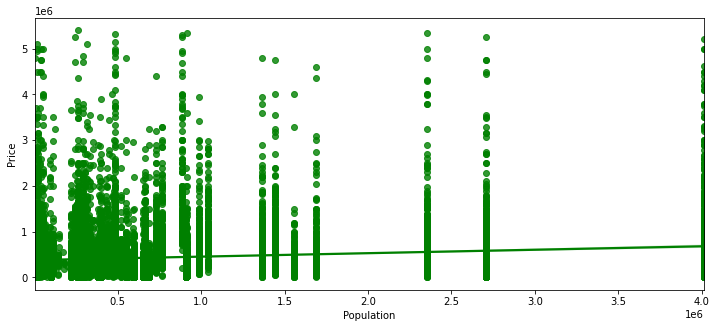

In [22]:
#regression plot for price vs population
plt.figure(figsize=(12,5))
sb.regplot(x="Population", y="Price", data=dfm, color='green')

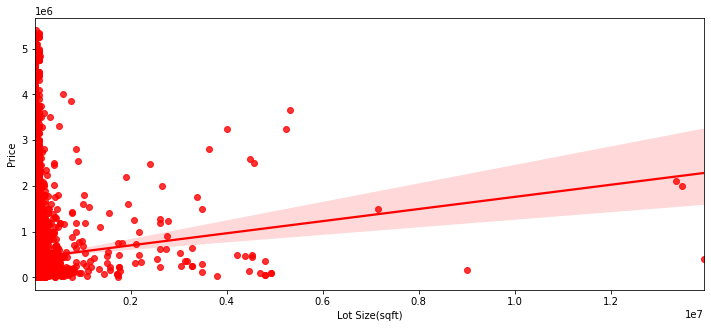

In [23]:
#regression plot for price vs lot size
plt.figure(figsize=(12,5))
sb.regplot(x="Lot Size(sqft)", y="Price", data=dfm, color='red')

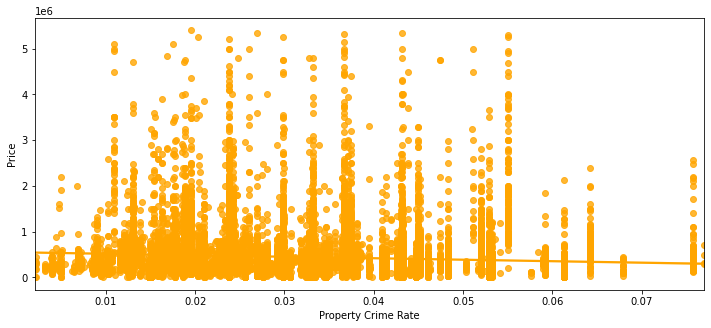

In [24]:
#regression plot for price vs property crime rate
plt.figure(figsize=(12,5))
sb.regplot(x="Property Crime Rate", y="Price", data=dfm, color='orange')

## 1-hot and Feature Scale

In [25]:
## 1-hot categorical variables: City, State  (create dummy variables)
## Feature Scale everything else

In [26]:
#check data types
dfm.dtypes

Price                  float64
Sqr Ft                 float64
Bedrooms               float64
Bathrooms              float64
Year Built             float64
Days On Trulia         float64
Lot Size(sqft)         float64
Price per Sqft         float64
Population               int64
Violent Crime Rate     float64
Property Crime Rate    float64
City                    object
State                   object
dtype: object

In [27]:
#Categorical to numbers for City (1-hot)
City_dummy = pd.get_dummies(dfm["City"], prefix='City', drop_first=True, columns=['City'])    #create k-1 dummy variables for k categories
City_dummy.head()

,City_Albuquerque,City_Anaheim,City_Anchorage,City_Apple Valley,City_Arlington,City_Atlantic Beach,City_Aurora,City_Austin,City_Aventura,City_Bainbridge Island,...,City_White Settlement,City_Whitefish Bay,City_Whitehall,City_Wichita,City_Windsor Heights,City_Winter Park,City_Wolfforth,City_Woodbury,City_Worthington,City_Yukon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Merge data from dfm and City_dummy
dfcd = pd.concat([dfm, City_dummy], axis=1)
#drop original column "City" from "dfcd"
dfcd.drop("City", axis = 1, inplace=True)
dfcd.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,City_White Settlement,City_Whitefish Bay,City_Whitehall,City_Wichita,City_Windsor Heights,City_Winter Park,City_Wolfforth,City_Woodbury,City_Worthington,City_Yukon
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#Categorical to numbers for State (1-hot)
State_dummy = pd.get_dummies(dfcd["State"], prefix='State', drop_first=True, columns=['State'])    #create k-1 dummy variables for k categories
State_dummy.head()

,State_AL,State_AZ,State_CA,State_CO,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,...,State_NY,State_OH,State_OK,State_OR,State_PA,State_TN,State_TX,State_VA,State_WA,State_WI
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Merge data from dfcd and State_dummy
dfsd = pd.concat([dfcd, State_dummy], axis=1)
#drop original column "State" from "dfsd"
dfsd.drop("State", axis = 1, inplace=True)
dfsd.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,State_NY,State_OH,State_OK,State_OR,State_PA,State_TN,State_TX,State_VA,State_WA,State_WI
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0


In [31]:
dfsd.dtypes

Price         float64
Sqr Ft        float64
Bedrooms      float64
Bathrooms     float64
Year Built    float64
               ...   
State_TN        uint8
State_TX        uint8
State_VA        uint8
State_WA        uint8
State_WI        uint8
Length: 381, dtype: object

In [32]:
#feature scale all numerical data using min and max
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

dfnum = dfsd.select_dtypes(exclude=['object'])

columnnames= list(dfsd.columns)     #save column names as a list

#Use MinMax scaler to normalize the data and feature scale between 0 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(dfnum)
scaled_df = pd.DataFrame(scaled_df, columns=columnnames)
print(scaled_df)

          Price    Sqr Ft  Bedrooms  Bathrooms  Year Built  Days On Trulia  \
0      0.165792  0.003848  0.428571   0.517241    1.000000        0.606742   
1      0.055577  0.002832  0.285714   0.448276    0.917160        0.696629   
2      0.194333  0.002727  0.428571   0.172414    0.662722        0.005618   
3      0.090798  0.002238  0.142857   0.241379    0.739645        1.000000   
4      0.035051  0.001933  0.428571   0.172414    0.786982        0.151685   
...         ...       ...       ...        ...         ...             ...   
21907  0.075049  0.003185  0.428571   0.310345    0.739645        0.005618   
21908  0.081335  0.002741  0.285714   0.310345    0.621302        0.707865   
21909  0.015169  0.001227  0.285714   0.172414    0.739645        0.752809   
21910  0.027550  0.001178  0.142857   0.172414    0.775148        0.370787   
21911  0.055239  0.002670  0.428571   0.310345    0.946746        0.000000   

       Lot Size(sqft)  Price per Sqft  Population  Violent Crim

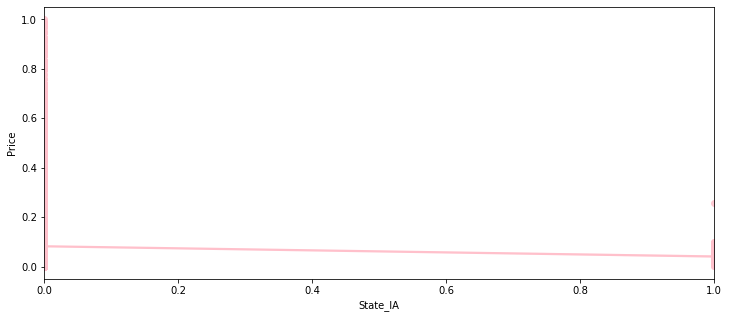

In [33]:
#regression plot for price vs State_IA
plt.figure(figsize=(12,5))
sb.regplot(x="State_IA", y="Price", data=scaled_df, color='pink')

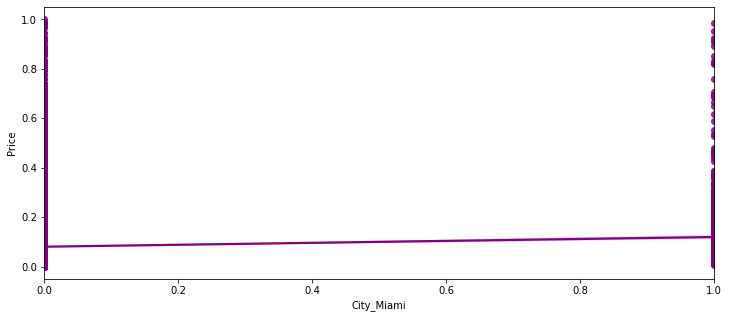

In [34]:
#regression plot for price vs City_Miami
plt.figure(figsize=(12,5))
sb.regplot(x="City_Miami", y="Price", data=scaled_df, color='purple')

## Regression Model

In [35]:
#Split data into training set(80%) and test set(20%) 
#Creating training and testing set by choosing random observations
rand = np.random.rand(len(scaled_df)) < 0.8
train = scaled_df[rand]
test = scaled_df[~rand]

Coefficients:  [[0.62412359]]
Intercept:  [0.0801065]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0017


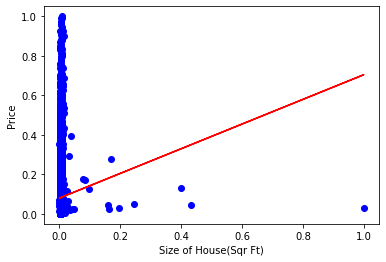

In [36]:
#Simple Linear regression for Price vs Size of House (Sqr Ft)
#Modeling
from sklearn import linear_model

regr = linear_model.LinearRegression()
train_x = train[['Sqr Ft']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Size of House(Sqr Ft)")
plt.ylabel("Price")

#Evaluation
#we compare the actual values and predicted values to calculate the accuracy of a regression model.
#There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set:
#- Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
#- Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error
#- R-squared is not error, but is a popular metric for accuracy of your model -higher R-squared is better
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['Sqr Ft']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[-0.0744793]]
Intercept:  [0.10684978]
Mean absolute error: 0.05
Residual sum of squares (MSE): 0.01
R2-score: 0.0303


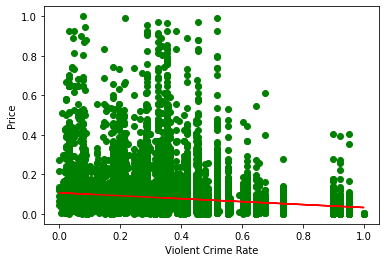

In [37]:
#Simple Linear regression for Price vs Violent Crime Rate

regr = linear_model.LinearRegression()
train_x = train[['Violent Crime Rate']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='green')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Violent Crime Rate")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Violent Crime Rate']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[-0.03832721]]
Intercept:  [0.08234014]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0022


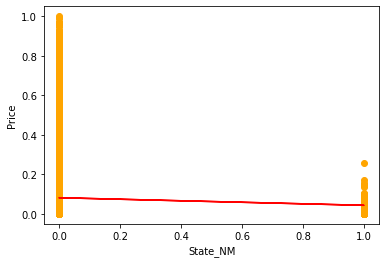

In [38]:
#Simple Linear regression for Price vs State_NM (New Mexico)

regr = linear_model.LinearRegression()
train_x = train[['State_NM']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='orange')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("State_NM")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['State_NM']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

In [40]:
# data transformation -logged variables??